<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/din%C3%A0mica_planet%C3%A0ria_STL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

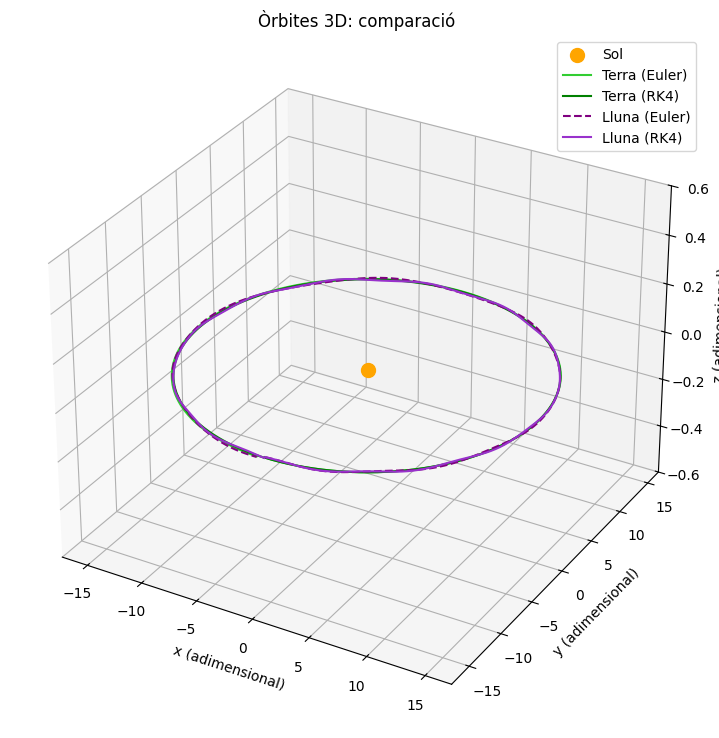

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juliol del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926947846045E+05, -1.526112945833626E+08, 5.512426763091981E+04, 2.865929048411513E+01, 7.673984975198109E-01, 6.367954761104172E-02])
terra= np.array([-4.133776193197704E+05, -1.528302631740080E+08, 3.242787546419352E+04, 2.932642969192311E+01, -7.378251225841874E-02, -1.172300943162528E-03])
sol= np.array([-6.709778526834890E+05, -8.035450223536204E+05, 2.366174814134883E+04, 1.263745636317092E-02, -3.212119035319765E-03, -2.265926685887389E-04])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic a partir de les dues constants anteriors

def normalitza(cos): # Primer passem a m i m/s, després normalitzem
  pos= cos[:3] * 1e3 / r0
  vel= cos[3:] * 1e3 * (t0 / r0)
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
posicions= np.array([pos_sol, pos_terra, pos_lluna])
velocitats= np.array([vel_sol, vel_terra, vel_lluna])

def acceleracions(pos, masses): # pos és matriu N files i 3 columnes
    N= len(masses) # Nombre de planetes
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def euler(pos, vel, masses, h):
    acc_euler= acceleracions(pos, masses)
    vel_nou= vel + h * acc_euler
    pos_nou= pos + h * vel
    return pos_nou, vel_nou

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

# Apliquem aquestes funcions a una simulació de duració 1 any terrestre
dies= 365
h= 1/24
passos= int(dies/h)
trajectoria_euler= np.zeros((passos+1, 3, 3))
trajectoria_rk4  = np.zeros((passos+1, 3, 3))
pos_euler, vel_euler= posicions.copy(), velocitats.copy()
pos_rk4, vel_rk4= posicions.copy(), velocitats.copy()
trajectoria_euler[0]= pos_euler
trajectoria_rk4[0]  = pos_rk4

for k in range(passos):
    pos_euler, vel_euler= euler(pos_euler, vel_euler, masses, h)
    pos_rk4, vel_rk4= rk4(pos_rk4, vel_rk4, masses, h)
    trajectoria_euler[k+1]= pos_euler
    trajectoria_rk4[k+1]  = pos_rk4

# GRÀFIC COMPARATIU
fig= plt.figure(figsize=(9,9))
ax= fig.add_subplot(111, projection="3d")
ax.scatter(trajectoria_rk4[0,0,0], trajectoria_rk4[0,0,1], trajectoria_rk4[0,0,2], color="orange", s=100, label="Sol")

ax.plot(trajectoria_euler[:,1,0], trajectoria_euler[:,1,1], trajectoria_euler[:,1,2], label="Terra (Euler)", color="limegreen")
ax.plot(trajectoria_rk4[:,1,0], trajectoria_rk4[:,1,1], trajectoria_rk4[:,1,2], label="Terra (RK4)", color="green")
ax.plot(trajectoria_euler[:,2,0], trajectoria_euler[:,2,1], trajectoria_euler[:,2,2], label="Lluna (Euler)", color="purple", linestyle="--")
ax.plot(trajectoria_rk4[:,2,0], trajectoria_rk4[:,2,1], trajectoria_rk4[:,2,2], label="Lluna (RK4)", color="darkorchid")

ax.set_xlabel("x (adimensional)")
ax.set_ylabel("y (adimensional)")
ax.set_zlabel("z (adimensional)")
ax.set_zlim([-0.6,0.6]) # A l'escala que té en compte
ax.set_title("Òrbites 3D: comparació")
ax.legend()
plt.show()